## Install Packages

Install `torch`, `torchvision` and `pytorch_gan_metrics`.

- Colab

    Use system default `torch` and `torchvision` to avoid hardware incompatibility.
    ```
    pip install pytorch_gan_metrics
    ```

- Custom environment (include `conda` users)

    Install all packages from pypi.
    ```
    pip install torch torchvision pytorch_gan_metrics
    ```

In [1]:
!pip install pytorch_gan_metrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
!pip install torch torchvision pytorch_gan_metrics

/bin/bash: line 1: pip install torch torchvision pytorch_gan_metrics: command not found


In [3]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00


In [4]:
from torchvision import transforms, datasets
from IPython.display import display
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import os
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import einops
from torchvision.utils import save_image,make_grid

In [5]:
BATCH_SIZE = 128
IMG_SIZE = 28
CHANNEL = 1
EPOCH = 200
SIZE = 20
lr = 0.0001
MODEL_DIR = '.\\model_weight\\'
root_train = '.\\train\\'

save_dir = os.path.join(MODEL_DIR)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [6]:
print(torch.__version__)
print(torch.version.cuda)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

2.2.1+cu121
12.1


## Building the Diffusion Model

We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

### Key Takeaways:
+ The noise-levels/variances can be pre-computed
+ There are different types of variance schedules
+ We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
+ No model is needed in this forward step

$$
q( x_t | x_0 ) = N( x_t; \sqrt{{\alpha}_t}x_t, (1-{\alpha}_t)I )
$$

In [7]:
# DDPM class
class DDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(DDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

## Show Images Functions

In [8]:
def show_tensor_image(image,save,idx=0):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[idx, :, :, :]
    if save == False:
        #print(str)
        #image = torch.clamp(image, min=-1, max=1)  # clamp [-1, 1]
        plt.imshow(reverse_transforms(image), cmap="gray")
        return image
    else:
        return image
    #plt.show()

def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch
        num_images = 6
        idx = 0
        plt.figure(figsize=(15,15))
        plt.axis('off')
        for percent in [0.0 ,0.2,0.4, 0.6, 0.8, 1]:
            plt.subplot(1, num_images + 1, idx + 1)
            if percent == 0.0:
                show_tensor_image(imgs,False)
            else:
                show_tensor_image(ddpm(imgs.to(device),
                    [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]).detach().cpu(),False)
            idx += 1
        break
    plt.show()

def generate_new_images(ddpm, n_samples=16, device=None, c=1, h=28, w=28,process=False):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    images = []
    with torch.no_grad():
        if device is None:
            device = ddpm.device

        if process == True:
            tmp = torch.zeros((n_samples, c, h, w), dtype=torch.float32).to(device)
            images = tmp.detach().cpu()

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)
        steps = int(ddpm.n_steps/6)
        #print('steps:', steps)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z
            if process and (idx ==0 or (idx+1) % steps==0) :
                images=torch.cat((images,x.detach().cpu()),0)
                #images.append(x)
        if process:
            return images
    #print(x.shape)
    return x

### Load Data set and observation

In [9]:
!unzip "/content/train.zip" -d "/content"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/train/5499.jpg  
  inflating: /content/train/55.jpg   
  inflating: /content/train/550.jpg  
  inflating: /content/train/5500.jpg  
  inflating: /content/train/5501.jpg  
  inflating: /content/train/5502.jpg  
  inflating: /content/train/5503.jpg  
  inflating: /content/train/5504.jpg  
  inflating: /content/train/5505.jpg  
  inflating: /content/train/5506.jpg  
  inflating: /content/train/5507.jpg  
  inflating: /content/train/5508.jpg  
  inflating: /content/train/5509.jpg  
  inflating: /content/train/551.jpg  
  inflating: /content/train/5510.jpg  
  inflating: /content/train/5511.jpg  
  inflating: /content/train/5512.jpg  
  inflating: /content/train/5513.jpg  
  inflating: /content/train/5514.jpg  
  inflating: /content/train/5515.jpg  
  inflating: /content/train/5516.jpg  
  inflating: /content/train/5517.jpg  
  inflating: /content/train/5518.jpg  
  inflating: /content/train/5519.jpg  
  infl

In [13]:
# Load Training Data
from PIL import Image
import glob
train_data = []

transform = transforms.Compose([
    #transforms.Pad(2, fill=0, padding_mode='constant'),
    #transforms.Resize((28,28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - 0.5) * 2)
    #transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
])

for im_path in glob.glob("/content/train/*.jpg"):
    train_data.append( transform(Image.open(im_path)))
print(len(train_data))


15746


In [14]:
data_loader = DataLoader( train_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True )

In [15]:
print(train_data[0].shape)# CHW

torch.Size([1, 28, 28])


## Training Model

In [16]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [17]:
class Block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(Block, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.ReLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        if self.normalize:
            out = self.ln(x)
        else:
            out = x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [18]:
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100, image_channels=1):
        super(UNet, self).__init__()
        down_channels = (image_channels,16, 32, 64)
        up_channels = (128 ,64, 32, 16)
        size = (28, 14, 7)
        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, down_channels[0])
        self.b1 = self._make_conv(down_channels[0], down_channels[1] ,down_channels[1], size[0] )
        self.down1 = nn.Conv2d(down_channels[1], down_channels[1], 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, down_channels[1])
        self.b2 = self._make_conv(down_channels[1], down_channels[2] ,down_channels[2], size[1] )
        self.down2 = nn.Conv2d(down_channels[2], down_channels[2], 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, down_channels[2])
        self.b3 = self._make_conv(down_channels[2], down_channels[3] ,down_channels[3], size[2] )
        self.down3 = nn.Sequential(
            nn.Conv2d(down_channels[3], down_channels[3], 2, 1),
            nn.ReLU(),
            nn.Conv2d(down_channels[3], down_channels[3], 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, down_channels[3])
        self.b_mid = nn.Sequential(
            Block((down_channels[3], 3, 3), down_channels[3], down_channels[2]),
            Block((down_channels[2], 3, 3), down_channels[2], down_channels[2]),
            Block((down_channels[2], 3, 3), down_channels[2], down_channels[3])
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(down_channels[3], down_channels[3], 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(down_channels[3], down_channels[3], 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, up_channels[0])
        self.b4 = self._make_conv(up_channels[0], up_channels[1] ,up_channels[2], size[2] )

        self.up2 = nn.ConvTranspose2d(up_channels[2], up_channels[2], 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, up_channels[1])
        self.b5 = self._make_conv(up_channels[1], up_channels[2] ,up_channels[3], size[1] )

        self.up3 = nn.ConvTranspose2d(up_channels[3], up_channels[3], 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, up_channels[2])
        self.b_out = self._make_conv(up_channels[2], up_channels[3] ,up_channels[3], size[0] )
        self.conv_out = nn.Conv2d(up_channels[3], 1, 3, 1, 1)

    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 16, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 32, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 64, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 64, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 128, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 32, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 64, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 16, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 32, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)
        out = self.conv_out(out)
        #print('Network:',out.shape)
        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.ReLU(),
            nn.Linear(dim_out, dim_out)
        )

    def _make_conv(self, in_c, mid_c, out_c, size, normalize=True ):
        return nn.Sequential(
            Block((in_c, size, size), in_c, mid_c),
            Block((mid_c, size, size), mid_c, out_c),
            Block((out_c, size, size), out_c, out_c,normalize=normalize)
        )
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
model = DDPM(UNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device).to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  1213704


DDPM(
  (network): UNet(
    (time_embed): Embedding(1000, 100)
    (te1): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1, out_features=1, bias=True)
    )
    (b1): Sequential(
      (0): Block(
        (ln): LayerNorm((1, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Block(
        (ln): LayerNorm((16, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Block(
        (ln): LayerNorm((16, 28, 28), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1)

## Setting noise to training image

<ipython-input-8-d76763e91e12>:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, idx + 1)


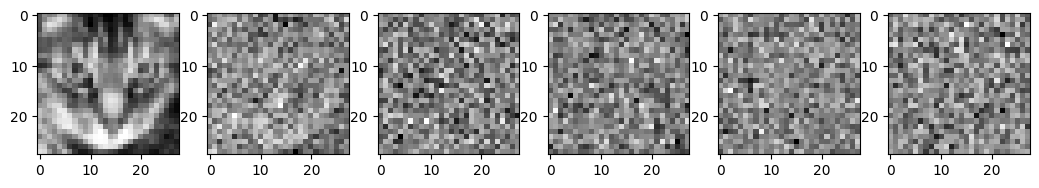

In [19]:
# Optionally, show the diffusion (forward) process
#for step, batch in enumerate(data_loader):
show_forward(model, data_loader, device)

### Show the denoising (backward) process

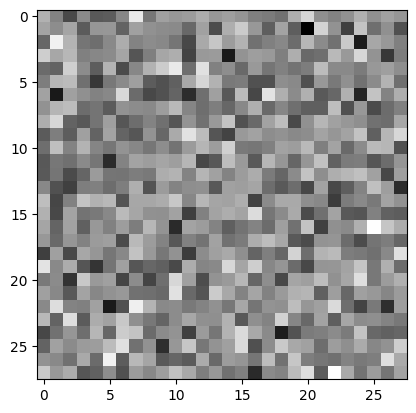

In [20]:
generated = generate_new_images(model,n_samples=1)
img = show_tensor_image(generated.detach().cpu(),False)

Epoch 0 | step 122 Loss: 0.2816601097583771 


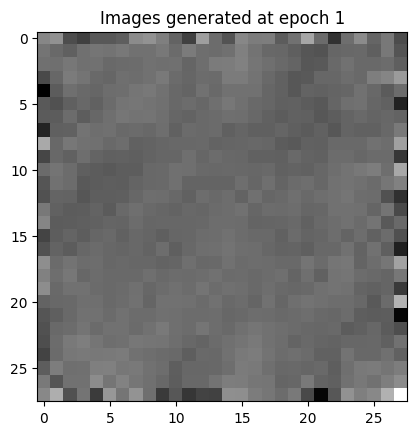

Loss at epoch 1: 0.646 --> Best model ever (stored)
Loss at epoch 2: 0.197 --> Best model ever (stored)
Loss at epoch 3: 0.129 --> Best model ever (stored)
Loss at epoch 4: 0.098 --> Best model ever (stored)
Loss at epoch 5: 0.087 --> Best model ever (stored)
Epoch 5 | step 122 Loss: 0.06701119989156723 


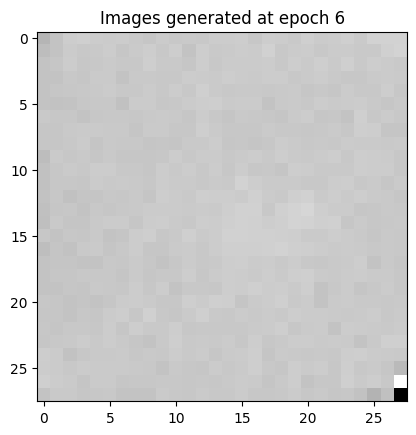

Loss at epoch 6: 0.081 --> Best model ever (stored)
Loss at epoch 7: 0.077 --> Best model ever (stored)
Loss at epoch 8: 0.072 --> Best model ever (stored)
Loss at epoch 9: 0.071 --> Best model ever (stored)
Loss at epoch 10: 0.070 --> Best model ever (stored)
Epoch 10 | step 122 Loss: 0.07540848851203918 


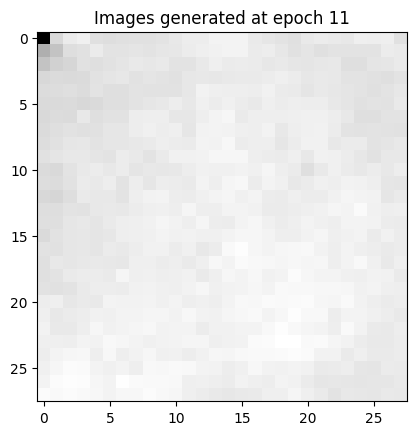

Loss at epoch 11: 0.067 --> Best model ever (stored)
Loss at epoch 12: 0.067 --> Best model ever (stored)
Loss at epoch 13: 0.066 --> Best model ever (stored)
Loss at epoch 14: 0.064 --> Best model ever (stored)
Loss at epoch 15: 0.064 --> Best model ever (stored)
Epoch 15 | step 122 Loss: 0.04708286002278328 


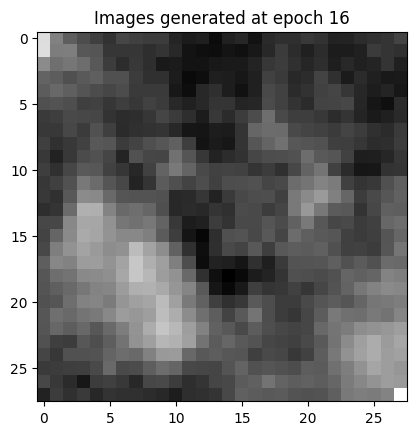

Loss at epoch 16: 0.063 --> Best model ever (stored)
Loss at epoch 17: 0.062 --> Best model ever (stored)
Loss at epoch 18: 0.063
Loss at epoch 19: 0.061 --> Best model ever (stored)
Loss at epoch 20: 0.060 --> Best model ever (stored)
Epoch 20 | step 122 Loss: 0.05282696709036827 


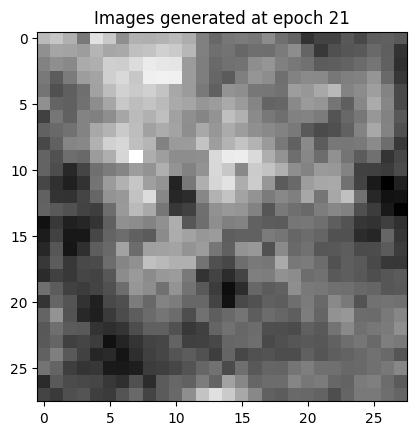

Loss at epoch 21: 0.060 --> Best model ever (stored)
Loss at epoch 22: 0.060 --> Best model ever (stored)
Loss at epoch 23: 0.058 --> Best model ever (stored)
Loss at epoch 24: 0.061
Loss at epoch 25: 0.059
Epoch 25 | step 122 Loss: 0.050025880336761475 


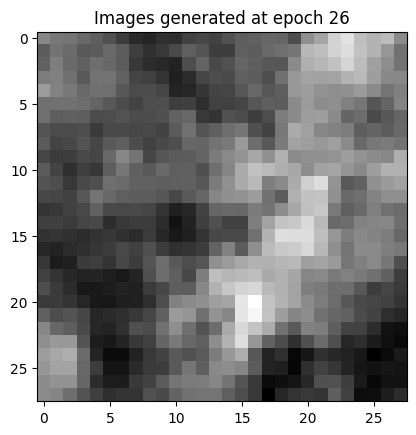

Loss at epoch 26: 0.059
Loss at epoch 27: 0.057 --> Best model ever (stored)
Loss at epoch 28: 0.058
Loss at epoch 29: 0.057 --> Best model ever (stored)
Loss at epoch 30: 0.056 --> Best model ever (stored)
Epoch 30 | step 122 Loss: 0.04837809503078461 


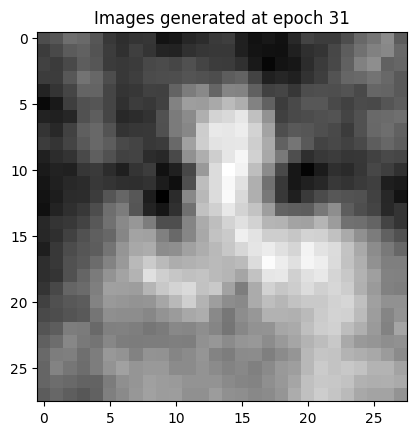

Loss at epoch 31: 0.057
Loss at epoch 32: 0.055 --> Best model ever (stored)
Loss at epoch 33: 0.054 --> Best model ever (stored)
Loss at epoch 34: 0.055
Loss at epoch 35: 0.055
Epoch 35 | step 122 Loss: 0.06194661557674408 


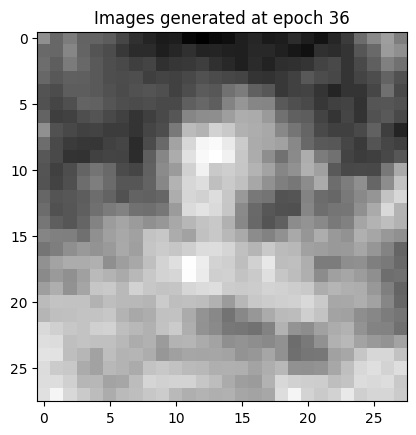

Loss at epoch 36: 0.053 --> Best model ever (stored)
Loss at epoch 37: 0.057
Loss at epoch 38: 0.053
Loss at epoch 39: 0.055
Loss at epoch 40: 0.055
Epoch 40 | step 122 Loss: 0.04760196805000305 


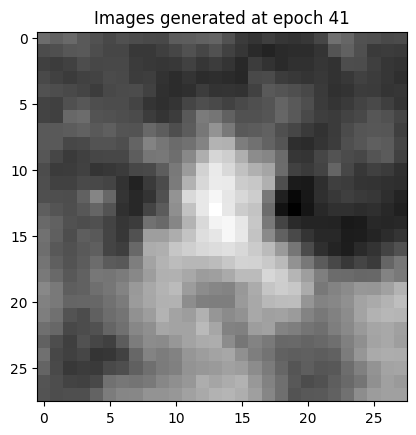

Loss at epoch 41: 0.054
Loss at epoch 42: 0.055
Loss at epoch 43: 0.055
Loss at epoch 44: 0.056
Loss at epoch 45: 0.055
Epoch 45 | step 122 Loss: 0.0455864816904068 


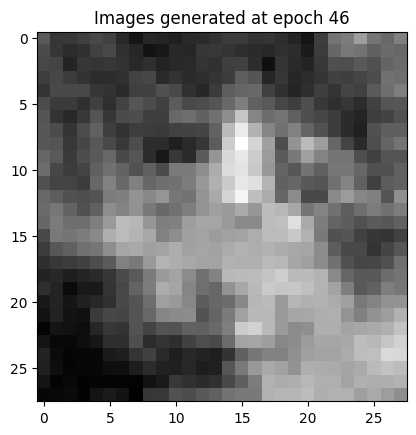

Loss at epoch 46: 0.055
Loss at epoch 47: 0.054
Loss at epoch 48: 0.055
Loss at epoch 49: 0.054
Loss at epoch 50: 0.054
Epoch 50 | step 122 Loss: 0.07742594927549362 


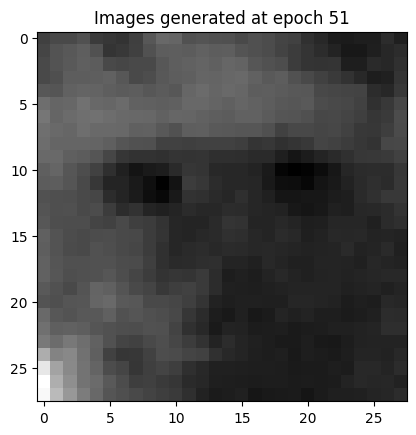

Loss at epoch 51: 0.053 --> Best model ever (stored)
Loss at epoch 52: 0.054
Loss at epoch 53: 0.052 --> Best model ever (stored)
Loss at epoch 54: 0.053
Loss at epoch 55: 0.053
Epoch 55 | step 122 Loss: 0.051554299890995026 


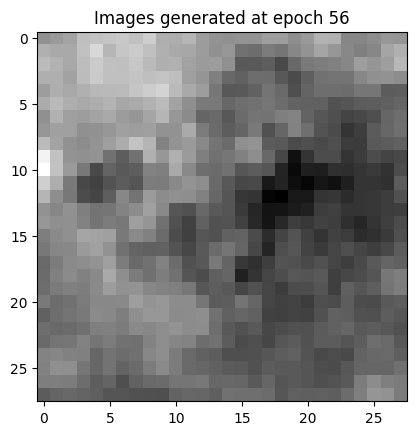

Loss at epoch 56: 0.053
Loss at epoch 57: 0.052
Loss at epoch 58: 0.053
Loss at epoch 59: 0.052
Loss at epoch 60: 0.051 --> Best model ever (stored)
Epoch 60 | step 122 Loss: 0.05416645109653473 


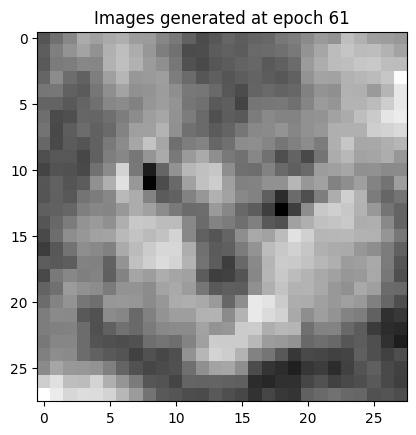

Loss at epoch 61: 0.053
Loss at epoch 62: 0.052
Loss at epoch 63: 0.054
Loss at epoch 64: 0.054
Loss at epoch 65: 0.053
Epoch 65 | step 122 Loss: 0.06006801873445511 


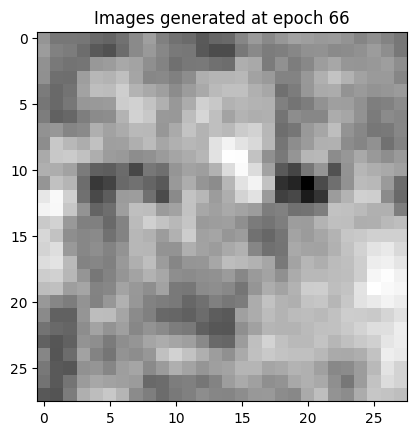

Loss at epoch 66: 0.053
Loss at epoch 67: 0.052
Loss at epoch 68: 0.052
Loss at epoch 69: 0.051 --> Best model ever (stored)
Loss at epoch 70: 0.054
Epoch 70 | step 122 Loss: 0.04652926325798035 


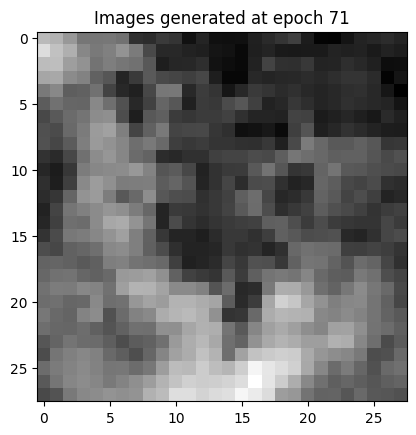

Loss at epoch 71: 0.053
Loss at epoch 72: 0.053
Loss at epoch 73: 0.052
Loss at epoch 74: 0.053
Loss at epoch 75: 0.052
Epoch 75 | step 122 Loss: 0.0779377818107605 


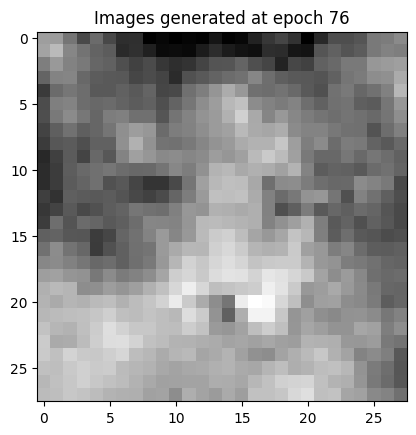

Loss at epoch 76: 0.052
Loss at epoch 77: 0.052
Loss at epoch 78: 0.051
Loss at epoch 79: 0.053
Loss at epoch 80: 0.052
Epoch 80 | step 122 Loss: 0.04803449288010597 


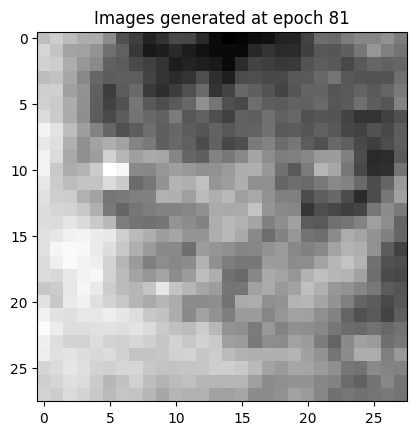

Loss at epoch 81: 0.052
Loss at epoch 82: 0.052
Loss at epoch 83: 0.052
Loss at epoch 84: 0.052
Loss at epoch 85: 0.052
Epoch 85 | step 122 Loss: 0.05379848927259445 


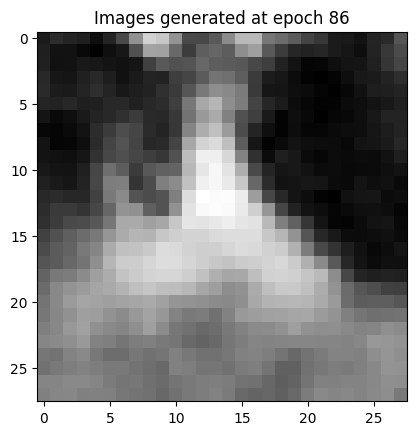

Loss at epoch 86: 0.053
Loss at epoch 87: 0.052
Loss at epoch 88: 0.050 --> Best model ever (stored)
Loss at epoch 89: 0.049 --> Best model ever (stored)
Loss at epoch 90: 0.050
Epoch 90 | step 122 Loss: 0.03757685050368309 


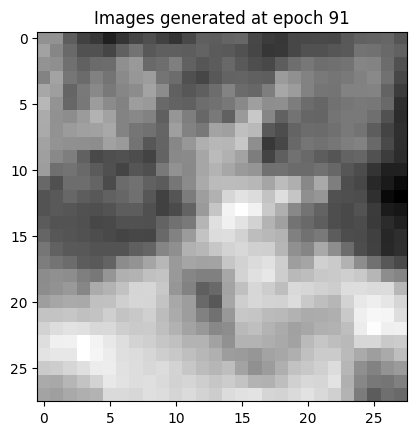

Loss at epoch 91: 0.052
Loss at epoch 92: 0.053
Loss at epoch 93: 0.052
Loss at epoch 94: 0.051
Loss at epoch 95: 0.051
Epoch 95 | step 122 Loss: 0.06269071251153946 


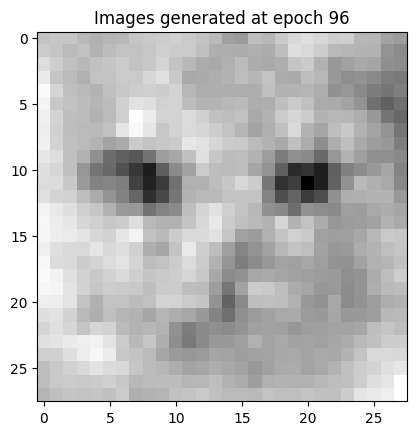

Loss at epoch 96: 0.052
Loss at epoch 97: 0.053
Loss at epoch 98: 0.051
Loss at epoch 99: 0.052
Loss at epoch 100: 0.052
Epoch 100 | step 122 Loss: 0.04994447901844978 


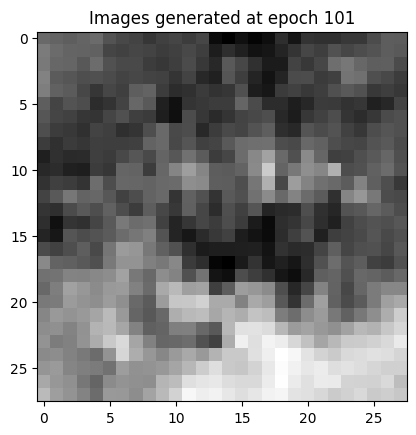

Loss at epoch 101: 0.052
Loss at epoch 102: 0.052
Loss at epoch 103: 0.050
Loss at epoch 104: 0.050
Loss at epoch 105: 0.052
Epoch 105 | step 122 Loss: 0.03483650088310242 


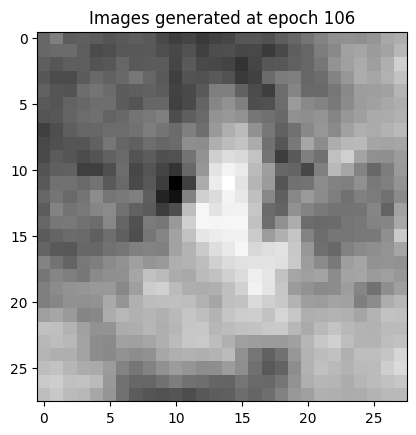

Loss at epoch 106: 0.049
Loss at epoch 107: 0.052
Loss at epoch 108: 0.050
Loss at epoch 109: 0.051
Loss at epoch 110: 0.050
Epoch 110 | step 122 Loss: 0.05835358798503876 


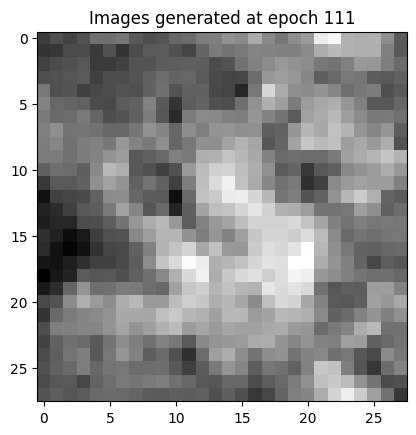

Loss at epoch 111: 0.049 --> Best model ever (stored)
Loss at epoch 112: 0.051
Loss at epoch 113: 0.052
Loss at epoch 114: 0.051
Loss at epoch 115: 0.050
Epoch 115 | step 122 Loss: 0.050144340842962265 


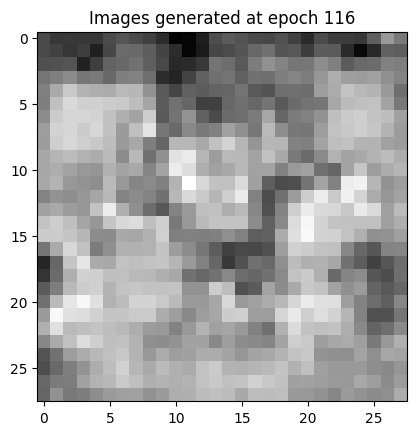

Loss at epoch 116: 0.053
Loss at epoch 117: 0.050
Loss at epoch 118: 0.049
Loss at epoch 119: 0.052
Loss at epoch 120: 0.051
Epoch 120 | step 122 Loss: 0.05026780813932419 


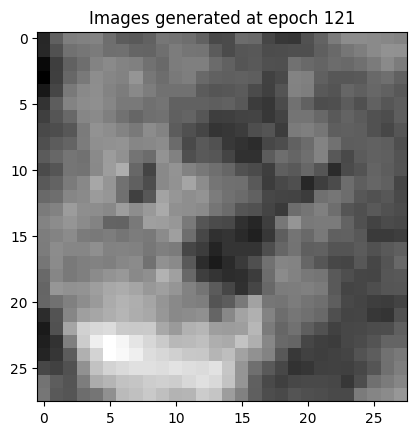

Loss at epoch 121: 0.050
Loss at epoch 122: 0.052
Loss at epoch 123: 0.050
Loss at epoch 124: 0.050
Loss at epoch 125: 0.051
Epoch 125 | step 122 Loss: 0.05119273439049721 


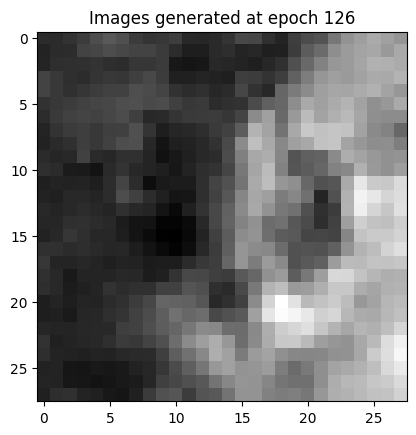

Loss at epoch 126: 0.051
Loss at epoch 127: 0.051
Loss at epoch 128: 0.052
Loss at epoch 129: 0.050
Loss at epoch 130: 0.051
Epoch 130 | step 122 Loss: 0.06278401613235474 


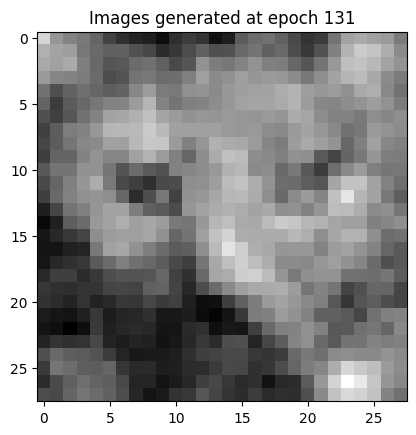

Loss at epoch 131: 0.051
Loss at epoch 132: 0.051
Loss at epoch 133: 0.051
Loss at epoch 134: 0.051
Loss at epoch 135: 0.051
Epoch 135 | step 122 Loss: 0.04466501623392105 


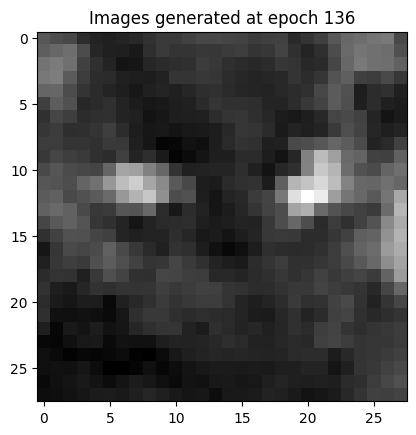

Loss at epoch 136: 0.051
Loss at epoch 137: 0.052
Loss at epoch 138: 0.052
Loss at epoch 139: 0.051
Loss at epoch 140: 0.050
Epoch 140 | step 122 Loss: 0.05203812196850777 


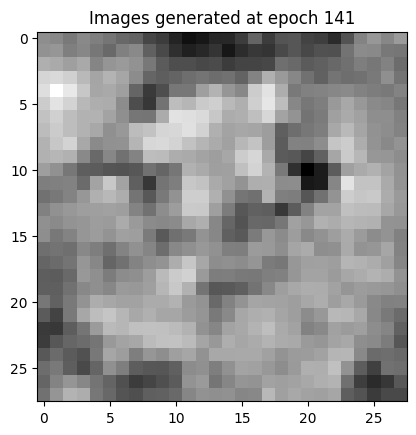

Loss at epoch 141: 0.049 --> Best model ever (stored)
Loss at epoch 142: 0.049
Loss at epoch 143: 0.051
Loss at epoch 144: 0.050
Loss at epoch 145: 0.050
Epoch 145 | step 122 Loss: 0.04636387899518013 


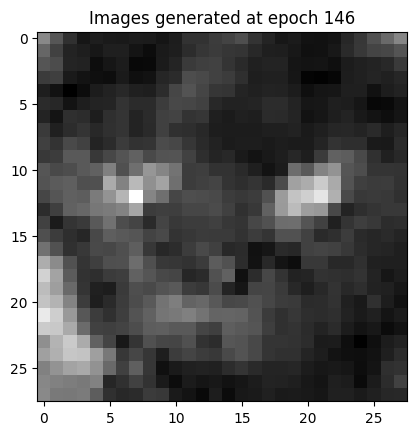

Loss at epoch 146: 0.050
Loss at epoch 147: 0.051
Loss at epoch 148: 0.051
Loss at epoch 149: 0.051
Loss at epoch 150: 0.049
Epoch 150 | step 122 Loss: 0.06091908738017082 


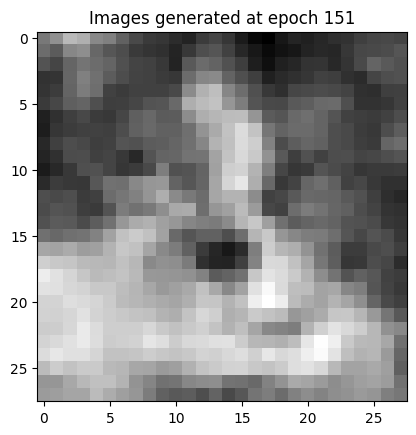

Loss at epoch 151: 0.051
Loss at epoch 152: 0.049
Loss at epoch 153: 0.050
Loss at epoch 154: 0.050
Loss at epoch 155: 0.050
Epoch 155 | step 122 Loss: 0.0500134713947773 


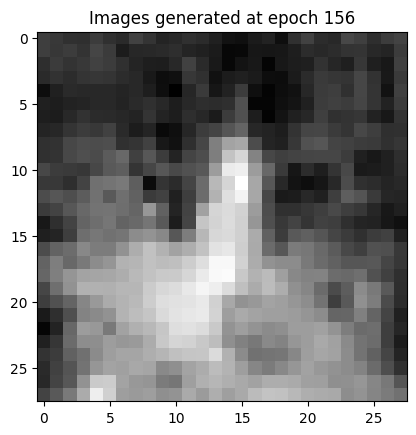

Loss at epoch 156: 0.049
Loss at epoch 157: 0.050
Loss at epoch 158: 0.052
Loss at epoch 159: 0.051
Loss at epoch 160: 0.050
Epoch 160 | step 122 Loss: 0.07255697250366211 


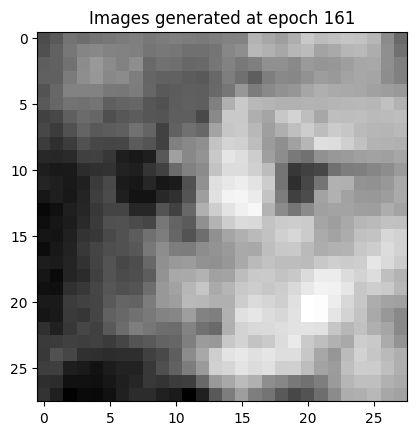

Loss at epoch 161: 0.050
Loss at epoch 162: 0.051
Loss at epoch 163: 0.050
Loss at epoch 164: 0.051
Loss at epoch 165: 0.050
Epoch 165 | step 122 Loss: 0.04910464212298393 


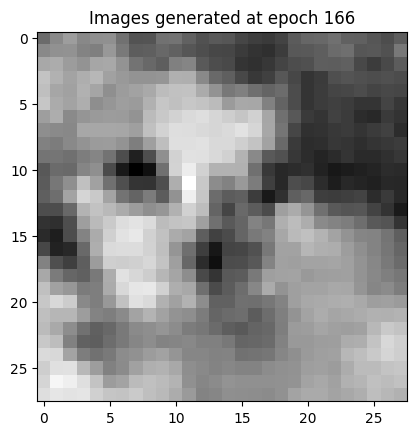

Loss at epoch 166: 0.051
Loss at epoch 167: 0.049
Loss at epoch 168: 0.051
Loss at epoch 169: 0.051
Loss at epoch 170: 0.050
Epoch 170 | step 122 Loss: 0.04687460884451866 


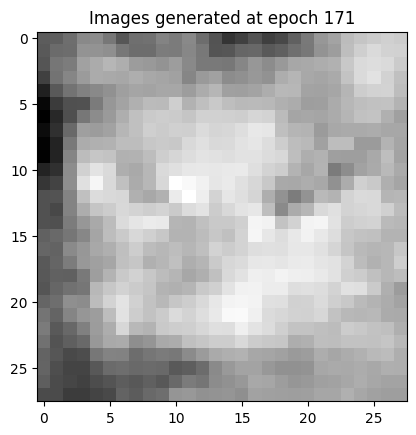

Loss at epoch 171: 0.050
Loss at epoch 172: 0.049
Loss at epoch 173: 0.051
Loss at epoch 174: 0.050
Loss at epoch 175: 0.050
Epoch 175 | step 122 Loss: 0.03249422833323479 


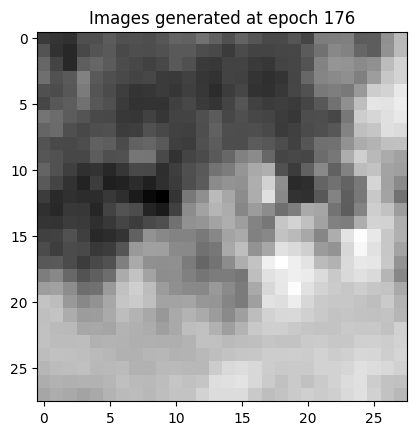

Loss at epoch 176: 0.051
Loss at epoch 177: 0.050
Loss at epoch 178: 0.052
Loss at epoch 179: 0.049
Loss at epoch 180: 0.049
Epoch 180 | step 122 Loss: 0.06630172580480576 


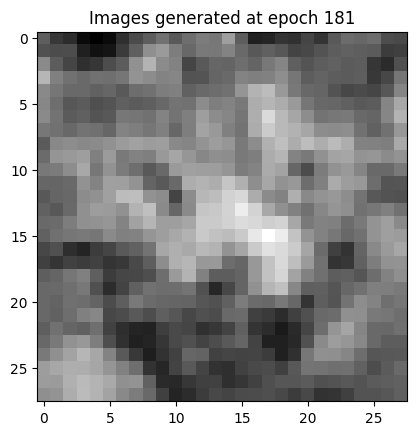

Loss at epoch 181: 0.050
Loss at epoch 182: 0.049
Loss at epoch 183: 0.049
Loss at epoch 184: 0.050
Loss at epoch 185: 0.049
Epoch 185 | step 122 Loss: 0.05632634833455086 


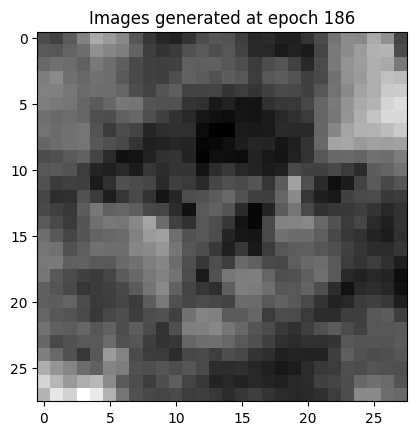

Loss at epoch 186: 0.048 --> Best model ever (stored)
Loss at epoch 187: 0.051
Loss at epoch 188: 0.049
Loss at epoch 189: 0.050
Loss at epoch 190: 0.049
Epoch 190 | step 122 Loss: 0.05095774680376053 


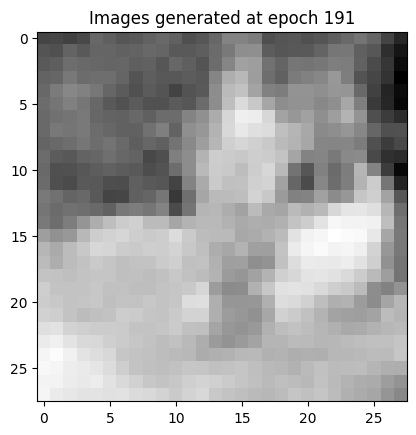

Loss at epoch 191: 0.050
Loss at epoch 192: 0.051
Loss at epoch 194: 0.051
Loss at epoch 195: 0.051
Epoch 195 | step 122 Loss: 0.049675583839416504 


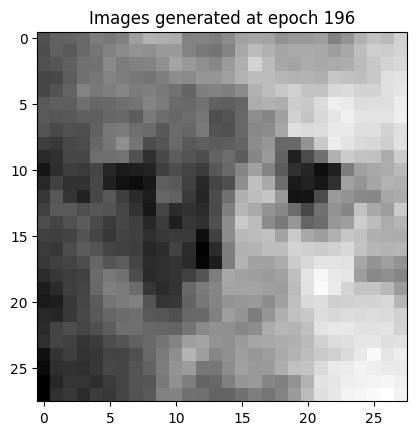

Loss at epoch 196: 0.051
Loss at epoch 197: 0.050
Loss at epoch 198: 0.052
Loss at epoch 199: 0.051
Loss at epoch 200: 0.050


In [21]:
from torch.optim import Adam
train_hist = {}
train_hist['loss'] = []
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()
best_loss = float("inf")
n_steps = model.n_steps
epochs = EPOCH # Try more!
ws_test = [0.0, 0.5, 2.0] # strength of generative guidance
for epoch in range(epochs):
    data_loader = DataLoader( train_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True )
    optimizer.param_groups[0]['lr'] = lr*(1-epoch/epochs)
    epoch_loss = 0.0
    for step, batch in enumerate(data_loader):
      optimizer.zero_grad()

      #t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      #print('batch:', batch.shape)
      x = batch.to(device)
      n = len(x)
      # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
      eta = torch.randn_like(x).to(device)
      t = torch.randint(0, n_steps, (n,)).to(device)
      # Computing the noisy image based on x0 and the time-step (forward process)
      noisy_imgs = model(x, t, eta)
      # Getting model estimation of noise based on the images and the time-step
      eta_theta = model.backward(noisy_imgs, t.reshape(n, -1))
      #print(eta_theta.shape,eta.shape)
      loss = mse(eta_theta, eta)
      train_hist['loss'].append(loss.item())
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item() * len(x) / len(data_loader.dataset)
    if epoch % 5 == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      img=generate_new_images(model,n_samples=4, device=device)
      #, f"Images generated at epoch {epoch + 1}"
      show_tensor_image(img.detach().cpu(),False)
      plt.title(f"Images generated at epoch {epoch + 1}")
      plt.show()
    log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"
    # Storing the model
    if best_loss > epoch_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), os.path.join(save_dir, 'testing.pt'))
        log_string += " --> Best model ever (stored)"
    print(log_string)

In [33]:
torch.save(model.state_dict(), os.path.join(save_dir, '/content/32_relu_diffusion_model_200_epoch.pt'))

## Denoising image

8


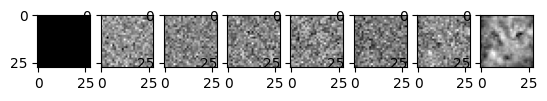

In [23]:
# Denoising
model.load_state_dict(torch.load(os.path.join(save_dir, '32_relu_diffusion_model_200_epoch.pt')))
imgs=generate_new_images(model,n_samples=1, device=device,process=True)
      #, f"Images generated at epoch {epoch + 1}"
print(len(imgs))
for idx,img in enumerate(imgs):
      plt.subplot(1, 7 + 1, idx + 1)
      show_tensor_image(img.detach().cpu(),False)

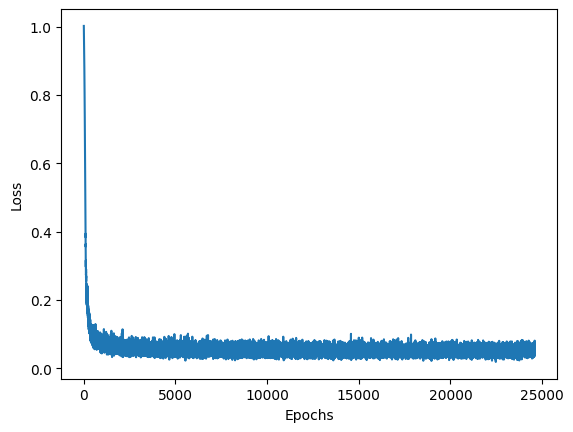

In [24]:
fig = plt.figure()
plt.plot(train_hist['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Generating Images
- Use `torch` to generate some noise as images.
- Use `torchvision.utils.save_image` to save `torch.Tensor` as an `png` image file.

Saving 00001.png
Saving 00002.png
Saving 00003.png
Saving 00004.png
Saving 00005.png
Saving 00006.png
Saving 00007.png
Saving 00008.png
Saving 00009.png
Saving 00010.png
Saving 00011.png
Saving 00012.png
Saving 00013.png
Saving 00014.png
Saving 00015.png
Saving 00016.png
Saving 00017.png
Saving 00018.png
Saving 00019.png
Saving 00020.png
Saving 00021.png
Saving 00022.png
Saving 00023.png
Saving 00024.png
Saving 00025.png
Saving 00026.png
Saving 00027.png
Saving 00028.png
Saving 00029.png
Saving 00030.png
Saving 00031.png
Saving 00032.png
Saving 00033.png
Saving 00034.png
Saving 00035.png
Saving 00036.png
Saving 00037.png
Saving 00038.png
Saving 00039.png
Saving 00040.png
Saving 00041.png
Saving 00042.png
Saving 00043.png
Saving 00044.png
Saving 00045.png
Saving 00046.png
Saving 00047.png
Saving 00048.png
Saving 00049.png
Saving 00050.png
Saving 00051.png
Saving 00052.png
Saving 00053.png
Saving 00054.png
Saving 00055.png
Saving 00056.png
Saving 00057.png
Saving 00058.png
Saving 00059.p

KeyboardInterrupt: 

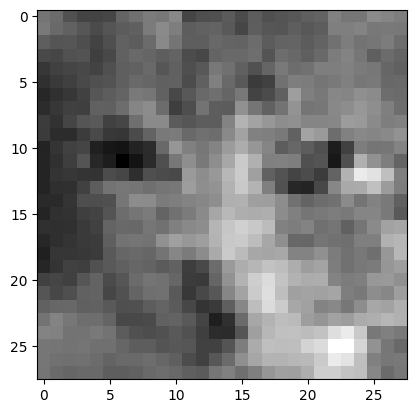

In [25]:
#model.load_state_dict(torch.load(os.path.join(save_dir, 'new_diffusion_model_100_epoch_best_29.pt')))
#model.to(device)
@torch.no_grad()
def plot_result_image():
    # Sample noise
    num_images = 100
    os.makedirs('./images', exist_ok=True)
    for j in range(num_images):
        path = os.path.join(f'./images/{j+1:05d}.png')
        image = generate_new_images(model,n_samples=1, device=device)
        img = show_tensor_image(image.detach().cpu(),False)
        print(f'Saving {j+1:05d}.png')
        save_image(img,path,normalize=True)

plot_result_image()

## Evaluate Generated Images at Runtime
- Use `torchvision.io.read_image` to load all images into memory one by one.
- Use `pytorch_gan_metrics.get_fid` to calculate FID between generated images in `./images` and our dataset (`mnist.npz`).

    The following is the document about how to use `get_fid` for reference.
    ```python
    from pytorch_gan_metrics import get_fid

    images = ...                                    # [N, 3, H, W] normalized to [0, 1]
    FID = get_fid(images, 'path/to/statistics.npz') # Frechet Inception Distance
    ```

The output FID should be the same as Checkpoint 2 (round to two decimal places).

In [32]:
from pytorch_gan_metrics import get_fid
from torchvision.io import read_image
num_images = 100
images = []
for i in range(num_images):
    path = os.path.join(f'./images/{i+1:05d}.png')
    image = read_image(path) / 255.
    images.append(image)
images = torch.stack(images, dim=0)
'''FID = get_fid(images,'./mnist.npz')
print(f'{FID:.5f}')'''

"FID = get_fid(images,'./mnist.npz')\nprint(f'{FID:.5f}')"

---

## Use `torchvision` to Save Grid Images

In [27]:
for i in range(8):
    print('Images idx: ',i)
    imgs = generate_new_images(model,n_samples=1, device=device,process=True)
    #print(imgs.shape)
    imge=show_tensor_image(imgs.detach().cpu(),True)
    #save_image(imge,'tmp.png')
    if i == 0:
        grid_imgs=imgs
    else:
        grid_imgs=torch.cat((grid_imgs,imgs),0)
    #print(grid_imgs.shape)


Images idx:  0
Images idx:  1
Images idx:  2
Images idx:  3
Images idx:  4
Images idx:  5
Images idx:  6
Images idx:  7


In [28]:
from PIL import Image
images = []
os.makedirs('./result', exist_ok=True)
for i in range(64):
    save_image( grid_imgs[i, :, :, :] ,f'./result/tmp_{i}.png',nrow=8,normalize=True)

result_data = []
transform_result=transforms.ToTensor()
for i in range(8):
    for j in range(8):
        im_path = f'./result/tmp_{i+8*j}.png'
        x =transform_result(Image.open(im_path))
        #print(x.shape)
        result_data.append( transform_result(Image.open(im_path)))

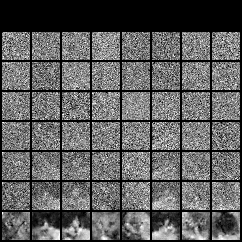

In [30]:
from IPython.display import Image, display

img = make_grid(result_data)
save_image(img,'tmp.png', normalize=True)
display(Image(filename='tmp.png'))